# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 2, #degree
        'n': 9, #number of variables
        'monomial_vars': None, #int or None
        'laurent': True, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': None,
        'x_max': 1,
        'x_min': 0.05,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 50000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'border_min': 0.2, #needs to be between 0 and (x_max-x_min)/2
        'border_max': 0.4,
        'lower_degree_prob': 0.5,
        'a_zero_prob': 0.25,
        'a_random_prob': 0.1,      
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'dropout_output': 0,
        'epochs': 100,
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 1000,
                
        'interpretation_net_output_monomials': None, #(None, int)
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number
        
        'normalize_inet_data': False,

        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': True,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 3,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': -3,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex, clear_output



In [4]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [5]:
from utilities.utility_functions import flatten, rec_gen

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    print(list_of_monomial_identifiers_extended)        
else:
    variable_sets = [[_d for _d in range(d+1)] for _ in range(n)]  
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)

    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity: ' + str(sparsity))
    print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    if np.sum(monomial_identifier) <= d:
        if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
            list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 19683
[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 2], [0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 2], [0, 0, 0, 0, 0, 0, 0, 2, 0], [0, 0, 0, 0, 0, 0, 0, 2, 1], [0, 0, 0, 0, 0, 0, 0, 2, 2], [0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 1], [0, 0, 0, 0, 0, 0, 1, 0, 2], [0, 0, 0, 0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 1, 1, 2], [0, 0, 0, 0, 0, 0, 1, 2, 0], [0, 0, 0, 0, 0, 0, 1, 2, 1], [0, 0, 0, 0, 0, 0, 1, 2, 2], [0, 0, 0, 0, 0, 0, 2, 0, 0], [0, 0, 0, 0, 0, 0, 2, 0, 1], [0, 0, 0, 0, 0, 0, 2, 0, 2], [0, 0, 0, 0, 0, 0, 2, 1, 0], [0, 0, 0, 0, 0, 0, 2, 1, 1], [0, 0, 0, 0, 0, 0, 2, 1, 2], [0, 0, 0, 0, 0, 0, 2, 2, 0], [0, 0, 0, 0, 0, 0, 2, 2, 1], [0, 0, 0, 0, 0, 0, 2, 2, 2], [0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 1], [0, 0, 0, 0, 0, 1, 0, 0, 2], [0, 0, 0, 0, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 1, 1], [0, 0, 0, 0, 0, 1, 0, 1, 2], [0, 0, 0, 0, 0, 1, 0, 2

  0%|          | 0/19683 [00:00<?, ?it/s]

List length: 55
[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 2], [0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 2, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 1], [0, 0, 0, 0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 0, 0, 2, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 1], [0, 0, 0, 0, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 1, 1, 0, 0], [0, 0, 0, 0, 0, 2, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0, 0, 1, 0], [0, 0, 0, 0, 1, 0, 1, 0, 0], [0, 0, 0, 0, 1, 1, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 1], [0, 0, 0, 1, 0, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 1, 0, 0, 0], [0, 0, 0, 1, 1, 0, 0, 0, 0], [0, 0, 0, 2, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 1], [0, 0, 1, 0, 0, 0, 0, 1, 0], [0, 0, 1, 0, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0, 0

In [6]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_55_drop0.25e100b256_custom/lnets_1000_275-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_9_d_2_laurent_negd_0_prob_0_spars_55_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1
lnets_50000_275-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_9_d_2_laurent_negd_0_prob_0_spars_55_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [9]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [10]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=-3)]: Using backend MultiprocessingBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 out of   1 | elapsed:  8.1min finished


## Data Inspection

In [11]:
lambda_net_dataset.as_pandas().head()

seed  000000000-target  000000001-target  000000002-target  \
33553  1373158606            -0.278            -0.667            -0.234   
9427   1373158606            -0.131             0.830            -0.700   
199    1373158606             0.360            -0.884             0.858   
12447  1373158606             0.088            -0.031            -0.050   
39489  1373158606            -0.554            -0.054            -0.761   

       000000010-target  000000011-target  000000020-target  000000100-target  \
33553            -0.161            -0.706             0.321            -0.960   
9427             -0.436            -0.003            -0.641             0.294   
199              -0.555             0.999            -0.657             0.543   
12447             0.522             0.888             0.295            -0.280   
39489            -0.447            -0.387             0.157             0.654   

       000000101-target  000000110-target  000000200-target  000001000-target  \
33553            -0.786            -0.789            -0.921            -0.466   
9427              0.403             0.083             0.710             0.852   
199              -0.553            -0.838             0.750             0.718   
12447            -0.620            -0.300             0.503             0.331   
39489            -0.644            -0.461            -0.230             0.321   

       000001001-target  000001010-target  000001100-target  000002000-target  \
33553             0.352             0.617            -0.600             0.188   
9427              0.654             0.580             0.576            -0.798   
199              -0.193             0.405             0.114             0.706   
12447             0.966             0.092             0.814            -0.631   
39489            -0.420             0.849            -0.870             0.717   

       000010000-target  000010001-target  000010010-target  000010100-target  \
33553            -0.186             0.003             0.787             0.512   
9427              0.431            -0.042            -0.664             0.823   
199              -0.370             0.047            -0.029            -0.292   
12447            -0.748            -0.376             0.412             0.489   
39489            -0.535             0.101             0.045            -0.776   

       000011000-target  000020000-target  000100000-target  000100001-target  \
33553             0.125            -0.271            -0.022             0.009   
9427             -0.509             0.561             0.794             0.064   
199               0.783            -0.668            -0.701             0.154   
12447            -0.218             0.363            -0.265             0.302   
39489             0.610             0.906            -0.538             0.135   

       000100010-target  000100100-target  000101000-target  000110000-target  \
33553            -0.102             0.896            -0.015             0.586   
9427              0.117             0.333             0.161            -0.337   
199               0.315            -0.611            -0.219             0.893   
12447            -0.662             0.732             0.486            -0.797   
39489            -0.625            -0.707             0.256            -0.123   

       000200000-target  001000000-target  001000001-target  001000010-target  \
33553             0.246            -0.532             0.500             0.028   
9427             -0.032            -0.438             0.936             0.499   
199              -0.507             0.337             0.480            -0.104   
12447             0.512            -0.421             0.605            -0.775   
39489             0.346             0.688            -0.276             0.955   

       001000100-target  001001000-target  001010000-target  001100000-target  \
33553            -0.403             0.341             0.372             

In [12]:
lambda_net_dataset.as_pandas().describe()

seed  000000000-target  000000001-target  000000002-target  \
count       1000.000          1000.000          1000.000          1000.000   
mean  1373158606.000            -0.000             0.018            -0.022   
std            0.000             0.580             0.568             0.577   
min   1373158606.000            -0.994            -0.996            -1.000   
25%   1373158606.000            -0.494            -0.466            -0.519   
50%   1373158606.000            -0.007             0.037            -0.029   
75%   1373158606.000             0.502             0.505             0.482   
max   1373158606.000             1.000             0.998             0.996   

       000000010-target  000000011-target  000000020-target  000000100-target  \
count          1000.000          1000.000          1000.000          1000.000   
mean             -0.014            -0.006             0.038            -0.015   
std               0.565             0.586             0.576             0.581   
min              -1.000            -0.999            -1.000            -0.999   
25%              -0.486            -0.544            -0.442            -0.532   
50%              -0.017             0.004             0.057            -0.041   
75%               0.440             0.515             0.551             0.475   
max               0.998             1.000             1.000             0.998   

       000000101-target  000000110-target  000000200-target  000001000-target  \
count          1000.000          1000.000          1000.000          1000.000   
mean             -0.028            -0.004            -0.001             0.006   
std               0.581             0.583             0.555             0.570   
min              -0.997            -0.997            -0.997            -0.999   
25%              -0.534            -0.515            -0.469            -0.465   
50%              -0.035            -0.018            -0.005             0.003   
75%               0.469             0.532             0.474             0.519   
max               0.998             0.996             0.998             1.000   

       000001001-target  000001010-target  000001100-target  000002000-target  \
count          1000.000          1000.000          1000.000          1000.000   
mean              0.009            -0.003            -0.010             0.049   
std               0.586             0.560             0.587             0.581   
min              -0.992            -0.999            -0.996            -0.998   
25%              -0.490            -0.468            -0.540            -0.457   
50%              -0.001             0.012             0.002             0.058   
75%               0.534             0.432             0.510             0.560   
max               0.999             0.999             0.996             1.000   

       000010000-target  000010001-target  000010010-target  000010100-target  \
count          1000.000          1000.000          1000.000          1000.000   
mean             -0.016             0.023            -0.015            -0.030   
std               0.577             0.578             0.565             0.577   
min              -0.999            -0.996            -1.000            -0.996   
25%              -0.487            -0.496            -0.502            -0.532   
50%              -0.010             0.062            -0.023            -0.031   
75%               0.467             0.524             0.466             0.481   
max               0.999             0.998             0.998             1.000   

       000011000-target  000020000-target  000100000-target  000100001-target  \
count          1000.000          1000.000          1000.000          1000.000   
mean             -0.036            -0.011            -0.031            -0.008   
std               0.571             0.565             0.565             0.566   
min              -1.000            -0.998            -0.996          

In [13]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[0.73082941, 0.05213017, 0.66572068, 0.87712713, 0.06067624,
        0.09081775, 0.72254459, 0.20717409, 0.4915632 ],
       [0.624057  , 0.90447014, 0.92468088, 0.93750586, 0.65198702,
        0.44290109, 0.35719106, 0.71362528, 0.38521999],
       [0.20728853, 0.3990572 , 0.23764756, 0.50852175, 0.94043697,
        0.8591    , 0.34855253, 0.87088499, 0.99980287],
       [0.58654567, 0.8845656 , 0.90932963, 0.90834534, 0.62394553,
        0.8081525 , 0.91104895, 0.75970973, 0.96291015],
       [0.8217497 , 0.33359407, 0.6376189 , 0.62417853, 0.67121809,
        0.66421107, 0.52845012, 0.51743737, 0.97099857],
       [0.60145068, 0.17803421, 0.38437711, 0.67995954, 0.98294559,
        0.52212317, 0.62965456, 0.13924224, 0.75433468],
       [0.7222318 , 0.81118147, 0.21146383, 0.56395218, 0.82417586,
        0.83460542, 0.3015649 , 0.88933477, 0.25549277],
       [0.73541227, 0.09589284, 0.53089947, 0.84096981, 0.90104095,
        0.86411768, 0.26617861, 0.48882316, 0.82097931],


In [14]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[-1.24438706],
       [ 0.54973534],
       [-0.43056807],
       [-0.87518897],
       [ 0.02303034],
       [-0.46104388],
       [ 1.43354167],
       [ 0.94475261],
       [ 0.74023684],
       [-0.85012547]])

## Generate Datasets for Interpretation-Net training

In [15]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        
        if isinstance(test_size, float):
            test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))
        
        test_seeds = random.sample(complete_seed_list, test_size)
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [16]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(810, 3192)

In [17]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(90, 3192)

In [18]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 3192)

In [19]:
lambda_net_train_dataset_list[-1].as_pandas().head()

seed  000000000-target  000000001-target  000000002-target  \
5946   1373158606             0.040            -0.623            -0.991   
49184  1373158606             0.796             0.088            -0.262   
4828   1373158606             0.836             0.960             0.673   
11538  1373158606            -0.009             0.072            -0.263   
18471  1373158606             0.783             0.840             0.312   

       000000010-target  000000011-target  000000020-target  000000100-target  \
5946             -0.089            -0.422             0.891            -0.404   
49184             0.876            -0.079             0.380             0.928   
4828             -0.148            -0.686            -0.930            -0.429   
11538            -0.325            -0.725             0.316             0.318   
18471            -0.637            -0.933             0.759             0.459   

       000000101-target  000000110-target  000000200-target  000001000-target  \
5946              0.083            -0.637            -0.544             0.050   
49184             0.671            -0.252            -0.503            -0.179   
4828             -0.849            -0.797            -0.403            -0.285   
11538             0.285            -0.390             0.433            -0.874   
18471            -0.097            -0.474             0.189            -0.910   

       000001001-target  000001010-target  000001100-target  000002000-target  \
5946              0.217             0.904            -0.979            -0.396   
49184             0.699             0.961             0.372            -0.385   
4828             -0.581             0.075            -0.875            -0.870   
11538            -0.573             0.329            -0.978            -0.545   
18471            -0.738             0.937            -0.198             0.584   

       000010000-target  000010001-target  000010010-target  000010100-target  \
5946             -0.572             0.845             0.755            -0.142   
49184            -0.483             0.004            -0.614             0.076   
4828              0.556            -0.393             0.816             0.799   
11538             0.387            -0.085             0.991             0.878   
18471            -0.175             0.402            -0.804             0.395   

       000011000-target  000020000-target  000100000-target  000100001-target  \
5946              0.295             0.727            -0.306            -0.335   
49184            -0.925             0.022             0.489             0.157   
4828             -0.161            -0.162             0.184            -0.481   
11538            -0.993            -0.314             0.329             0.077   
18471             0.282            -0.561             0.069             0.277   

       000100010-target  000100100-target  000101000-target  000110000-target  \
5946              0.963            -0.538             0.419             0.348   
49184            -0.933             0.259            -0.139            -0.779   
4828             -0.982            -0.824            -0.241             0.017   
11538             0.986             0.045            -0.856            -0.004   
18471            -0.338            -0.769            -0.232            -0.637   

       000200000-target  001000000-target  001000001-target  001000010-target  \
5946              0.935            -0.392            -0.127             0.776   
49184            -0.175             0.682            -0.956             0.908   
4828              0.925             0.529            -0.694             0.587   
11538             0.508            -0.917             0.269             0.613   
18471             0.613             0.919            -0.423             0.895   

       001000100-target  001001000-target  001010000-target  001100000-target  \
5946             -0.953             0.275            -0.453            -

In [20]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

seed  000000000-target  000000001-target  000000002-target  \
12187  1373158606             0.275             0.115             0.756   
48063  1373158606             0.372             0.608            -0.829   
6354   1373158606             0.754            -0.694            -0.064   
48394  1373158606             0.833             0.484            -0.614   
48492  1373158606            -0.223             0.146             0.473   

       000000010-target  000000011-target  000000020-target  000000100-target  \
12187             0.680             0.372             0.101             0.110   
48063            -0.414             0.948            -0.129            -0.921   
6354              0.041            -0.081             0.952             0.420   
48394             0.969            -0.283            -0.382             0.433   
48492            -0.302             0.547             0.631            -0.749   

       000000101-target  000000110-target  000000200-target  000001000-target  \
12187             0.039            -0.044            -0.437            -0.151   
48063             0.151             0.602             0.125             0.507   
6354              0.401            -0.254            -0.684             0.201   
48394             0.179            -0.639             0.459            -0.243   
48492             0.081            -0.109            -0.623            -0.414   

       000001001-target  000001010-target  000001100-target  000002000-target  \
12187             0.320             0.013            -0.993            -0.646   
48063            -0.923             0.410            -0.639            -0.235   
6354              0.687             0.612             0.737             0.695   
48394            -0.444            -0.024            -0.260            -0.419   
48492             0.694            -0.279            -0.325             0.880   

       000010000-target  000010001-target  000010010-target  000010100-target  \
12187             0.815            -0.962            -0.217            -0.709   
48063             0.729            -0.778            -0.188             0.409   
6354              0.550            -0.538             0.989             0.219   
48394            -0.535             0.728             0.698             0.380   
48492            -0.107             0.583             0.501            -0.892   

       000011000-target  000020000-target  000100000-target  000100001-target  \
12187             0.322            -0.300            -0.041            -0.866   
48063            -0.025             0.692            -0.050             0.134   
6354             -0.306             0.905            -0.983             0.414   
48394            -0.283             0.289            -0.953             0.105   
48492             0.246             0.281             0.222            -0.566   

       000100010-target  000100100-target  000101000-target  000110000-target  \
12187             0.023            -0.061            -0.447             0.155   
48063             0.594             0.455            -0.715             0.232   
6354              0.485             0.229            -0.258             0.497   
48394             0.445             0.249             0.077             0.795   
48492             0.330             0.555             0.066             0.024   

       000200000-target  001000000-target  001000001-target  001000010-target  \
12187             0.070             0.984             0.976             0.321   
48063             0.928            -0.951             0.492             0.166   
6354             -0.459            -0.875            -0.759             0.451   
48394            -0.357            -0.623            -0.411            -0.602   
48492             0.196             0.230             0.740             0.122   

       001000100-target  001001000-target  001010000-target  001100000-target  \
12187             0.037             0.177             0.987            -

In [21]:
lambda_net_test_dataset_list[-1].as_pandas().head()

seed  000000000-target  000000001-target  000000002-target  \
25480  1373158606            -0.881             0.601             0.717   
37915  1373158606             0.882            -0.659             0.940   
26089  1373158606             0.836             0.517             0.260   
29046  1373158606             0.113             0.801            -0.432   
12083  1373158606             0.562            -0.012             0.016   

       000000010-target  000000011-target  000000020-target  000000100-target  \
25480             0.975            -0.339             0.264             0.765   
37915             0.201            -0.282             0.443            -0.703   
26089             0.173            -0.546             0.652            -0.668   
29046            -0.584             0.734             0.602             0.984   
12083            -0.228            -0.292            -0.829            -0.699   

       000000101-target  000000110-target  000000200-target  000001000-target  \
25480            -0.841            -0.795             0.065             0.001   
37915            -0.760             0.893             0.458             0.092   
26089            -0.450            -0.648            -0.315             0.589   
29046             0.483             0.269            -0.485            -0.143   
12083             0.364            -0.313            -0.098            -0.840   

       000001001-target  000001010-target  000001100-target  000002000-target  \
25480             0.943            -0.559            -0.790             0.533   
37915             0.962            -0.410            -0.844            -0.441   
26089            -0.848            -0.793             0.946            -0.704   
29046            -0.131             0.992            -0.793            -0.163   
12083             0.142            -0.638             0.307            -0.842   

       000010000-target  000010001-target  000010010-target  000010100-target  \
25480            -0.415             0.084            -0.606            -0.016   
37915            -0.947             0.956             0.590            -0.339   
26089            -0.475            -0.659             0.055            -0.944   
29046             0.122            -0.337            -0.519             0.957   
12083            -0.459            -0.484            -0.296            -0.084   

       000011000-target  000020000-target  000100000-target  000100001-target  \
25480             0.938             0.177             0.333            -0.921   
37915            -0.584             0.517             0.256            -0.733   
26089             0.372            -0.257             0.426             0.189   
29046            -0.941             0.117            -0.670            -0.973   
12083            -0.831            -0.935             0.920             0.683   

       000100010-target  000100100-target  000101000-target  000110000-target  \
25480            -0.419             0.552            -0.403             0.546   
37915            -0.207             0.255             0.474            -0.163   
26089             0.628             0.732             0.980             0.709   
29046            -0.597             0.309             0.992             0.643   
12083            -0.875            -0.369             0.209            -0.988   

       000200000-target  001000000-target  001000001-target  001000010-target  \
25480             0.471             0.633             0.895             0.336   
37915             0.846            -0.802             0.668            -0.986   
26089             0.555             0.027            -0.855             0.209   
29046             0.457             0.670            -0.483             0.870   
12083             0.170             0.343            -0.573             0.551   

       001000100-target  001001000-target  001010000-target  001100000-target  \
25480            -0.742            -0.417            -0.917             

## Interpretation Network Training

In [22]:
#%load_ext autoreload

In [23]:
#%autoreload 2
(history_list, 

#scores_valid_list,
scores_test_list, 

#function_values_valid_list, 
function_values_test_list, 

#polynomial_dict_valid_list,
polynomial_dict_test_list,

#distrib_dict_valid_list,
distrib_dict_test_list,

model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

Trial 3 Complete [00h 01m 52s]
val_loss: 0.4155324697494507

Best val_loss So Far: 0.4008270800113678
Total elapsed time: 00h 05m 31s
Training Time: 0:05:35
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------ LOADING MODELS -----------------------------------------------------
Loading Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- PREDICT INET ------------------------------------------------------
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3026)]            0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 3026)     

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  4.1min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 13.5min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  4.1min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 13.5min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  4.3min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 13.3min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  3.8min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 12.7min finished
Traceback (most recent call last):
  File "../utilities/InterpretationNet.py", line 1085, in calculate_all_function_values
    function_valu

<class 'KeyError'>
<class 'KeyError'>
<class 'KeyError'>
'symbolic_regression_functions'
EXIT symbolic_regression_functions
<class 'KeyError'>
FV Calculation Time: 0:53:17
---------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------
lambda_preds_VS_target_polynomials
[[ 1.0930691   0.34991825 -0.14890477 ...  0.66450894  0.9842394
  -0.8281209 ]
 [ 1.1118314  -0.28055197  0.31441194 ...  2.00445     1.8835056
   1.4421306 ]
 [ 0.5323078  -1.1410247  -0.43964    ... -0.39689898  1.2125137
   0.430133  ]
 ...
 [ 1.0586634   1.18792     0.13073166 ...  2.3868973   1.0434102
   1.2154757 ]
 [-2.5786014  -3.6713192  -2.2795684  ... -2.4308403  -2.0315268
  -1.2169099 ]
 [-0.30026084 -1.8631498   0.8192187  ...  0.10199166 -0.3449235
  -0.7630128 ]]
[[ 1.0995852   0.32955855 -0.1671843  ...  0.6201254   0.94

## Evaluate Interpretation Net

In [24]:
poly_optimize = tf.constant([float(i) for i in range(interpretation_net_output_shape)])

if interpretation_net_output_monomials != None:
    poly_optimize_coeffs = poly_optimize[:interpretation_net_output_monomials]

    poly_optimize_identifiers_list = []
    for i in range(interpretation_net_output_monomials):
        poly_optimize_identifiers = tf.math.softmax(poly_optimize[sparsity*i+interpretation_net_output_monomials:sparsity*(i+1)+interpretation_net_output_monomials])
        poly_optimize_identifiers_list.append(poly_optimize_identifiers)
    poly_optimize_identifiers_list = tf.keras.backend.flatten(poly_optimize_identifiers_list)
    poly_optimize = tf.concat([poly_optimize_coeffs, poly_optimize_identifiers_list], axis=0)


In [25]:
poly_optimize

<tf.Tensor: shape=(55,), dtype=float32, numpy=
array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54.], dtype=float32)>

In [26]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: True
dense_block_1/num_layers: 2
dense_block_1/units_0: 32
dense_block_1/dropout: 0.0
dense_block_1/units_1: 32
regression_head_1/dropout: 0.25
optimizer: adam
learning_rate: 0.001
Score: 0.4008270800113678
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 2
dense_block_1/units_0: 32
dense_block_1/dropout: 0.0
dense_block_1/units_1: 32
regression_head_1/dropout: 0.25
optimizer: adam
learning_rate: 0.001
Score: 0.4155324697494507
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: True
dense_block_1/num_layers: 2
dense_block_1/units_0: 32
dense_block_1/dropout: 0.0
dense_block_1/units_1: 32
regression_head_1/dropout: 0
optimizer: adam
learning_rate: 0.001
Score: 0.42965176701545715
None


In [27]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3026)]            0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 3026)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                96864     
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128   

In [28]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [29]:
scores_test_list[-1].index

Index(['lambda_preds_VS_target_polynomials',
       'lambda_preds_VS_lstsq_lambda_pred_polynomials',
       'lambda_preds_VS_lstsq_target_polynomials',
       'lambda_preds_VS_inet_polynomials',
       'target_polynomials_VS_lstsq_lambda_pred_polynomials',
       'target_polynomials_VS_lstsq_target_polynomials',
       'target_polynomials_VS_inet_polynomials',
       'lstsq_lambda_pred_polynomials_VS_lstsq_target_polynomials',
       'lstsq_lambda_pred_polynomials_VS_inet_polynomials',
       'lstsq_target_polynomials_VS_inet_polynomials'],
      dtype='object')

In [30]:
scores_test_list[-1]

MAE  RMSE  MAPE  \
lambda_preds_VS_target_polynomials                   NaN   NaN   NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials        NaN   NaN   NaN   
lambda_preds_VS_lstsq_target_polynomials             NaN   NaN   NaN   
lambda_preds_VS_inet_polynomials                     NaN   NaN   NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.056 0.081 0.340   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.465 0.550 1.942   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.056 0.081 0.369   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.440 0.522 1.912   
lstsq_target_polynomials_VS_inet_polynomials       0.465 0.550 1.942   

                                                    Accuracy  \
lambda_preds_VS_target_polynomials                       NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials            NaN   
lambda_preds_VS_lstsq_target_polynomials                 NaN   
lambda_preds_VS_inet_polynomials                         NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...     0.533   
target_polynomials_VS_lstsq_target_polynomials         1.000   
target_polynomials_VS_inet_polynomials                 0.058   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...     0.533   
lstsq_lambda_pred_polynomials_VS_inet_polynomials      0.058   
lstsq_target_polynomials_VS_inet_polynomials           0.058   

                                                    Accuracy Multilabel  \
lambda_preds_VS_target_polynomials                                  NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials                       NaN   
lambda_preds_VS_lstsq_target_polynomials                            NaN   
lambda_preds_VS_inet_polynomials                                    NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...                0.000   
target_polynomials_VS_lstsq_target_polynomials                    1.000   
target_polynomials_VS_inet_polynomials                            0.000   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...                0.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials                 0.000   
lstsq_target_polynomials_VS_inet_polynomials                      0.000   

                                                    MAE FV  RMSE FV  MAPE FV  \
lambda_preds_VS_target_polynomials                   0.031    0.044    0.141   
lambda_preds_VS_lstsq_lambda_pred_polynomials        0.028    0.038    0.119   
lambda_preds_VS_lstsq_target_polynomials             0.031    0.044    0.141   
lambda_preds_VS_inet_polynomials                     0.418    0.520    2.483   
target_polynomials_VS_lstsq_lambda_pred_polynom...   0.022    0.029    0.123   
target_polynomials_VS_lstsq_target_polynomials       0.000    0.000    0.000   
target_polynomials_VS_inet_polynomials               0.423    0.528    2.525   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...   0.022    0.029    0.119   
lstsq_lambda_pred_polynomials_VS_inet_polynomials    0.416    0.519    2.082   
lstsq_target_polynomials_VS_inet_polynomials         0.423    0.528    2.525   

                                                    R2 FV  RAAE FV  RMAE FV  \
lambda_preds_VS_target_polynomials                  0.998    0.033    0.246   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.998    0.030    0.196   
lambda_preds_VS_lstsq_target_polynomials            0.998    0.033    0.246   
lambda_preds_VS_inet_polynomials                    0.687    0.435    1.604   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.999    0.023    0.113   
target_polynomials_VS_lstsq_target_polynomials      1.000    0.000    0.000   
target_polynomials_VS_inet_polynomials              0.684    0.436    1.713   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...  0.999    0.023    0.107   
lstsq_lambda_pred_polynomials_VS_inet_polynomials   0.687    0.433    1.681   
lstsq_target_polynomials_VS_inet_polynomials        0.684 

In [31]:
distrib_dict_test_list[-1]['MAE']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.034 0.029 0.038 0.023   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.034 0.026 0.036 0.022   
lambda_preds_VS_lstsq_target_polynomials           0.034 0.029 0.038 0.023   
lambda_preds_VS_inet_polynomials                   0.373 0.399 0.560 0.321   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.021 0.022 0.026 0.020   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.376 0.399 0.561 0.325   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.021 0.022 0.026 0.020   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.368 0.395 0.559 0.320   
lstsq_target_polynomials_VS_inet_polynomials       0.376 0.399 0.561 0.325   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.030 0.027 0.039 0.027   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.029 0.025 0.036 0.024   
lambda_preds_VS_lstsq_target_polynomials           0.030 0.027 0.039 0.027   
lambda_preds_VS_inet_polynomials                   0.718 0.661 0.475 0.324   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.020 0.020 0.031 0.017   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.724 0.662 0.487 0.331   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.020 0.020 0.031 0.017   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.716 0.657 0.467 0.323   
lstsq_target_polynomials_VS_inet_polynomials       0.724 0.662 0.487 0.331   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.030 0.031 0.025 0.033   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.027 0.029 0.023 0.030   
lambda_preds_VS_lstsq_target_polynomials           0.030 0.031 0.025 0.033   
lambda_preds_VS_inet_polynomials                   0.379 0.487 0.308 0.476   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.018 0.022 0.016 0.024   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.381 0.493 0.314 0.473   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.018 0.022 0.016 0.024   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.378 0.486 0.307 0.470   
lstsq_target_polynomials_VS_inet_polynomials       0.381 0.493 0.314 0.473   

                                                    L-12  L-13  L-14  L-15  \
lambda_preds_VS_target_polynomials                 0.031 0.030 0.023 0.027   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.028 0.029 0.023 0.025   
lambda_preds_VS_lstsq_target_polynomials           0.031 0.030 0.023 0.027   
lambda_preds_VS_inet_polynomials                   0.423 0.322 0.301 0.300   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.024 0.023 0.016 0.016   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.432 0.329 0.303 0.305   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.024 0.023 0.016 0.016   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.423 0.324 0.295 0.299   
lstsq_target_polynomials_VS_inet_polynomials       0.432 0.329 0.303 0.305   

                                                    L-16  L-17  L-18  L-19  \
lambda_preds_VS_target_polynomials                 0.032 0.024 0.037 0.031   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.031 0.022 0.034 0.027   
lambda_preds_VS_lstsq_target_polynomials           0.032 0.024 0.037 0.031   
lambda_preds_VS_inet_polynomials                   0.525 0.411 0.609 0.238   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.028 0.016 0.027 0.026   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.533 0.415 0.616 0.

In [32]:
distrib_dict_test_list[-1]['R2']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.997 0.997 0.998 0.998   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.998 0.998 0.999 0.998   
lambda_preds_VS_lstsq_target_polynomials           0.997 0.997 0.998 0.998   
lambda_preds_VS_inet_polynomials                   0.745 0.599 0.723 0.665   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.999 0.999 0.999 0.999   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.741 0.604 0.719 0.661   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.999 0.999 0.999 0.999   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.745 0.604 0.723 0.665   
lstsq_target_polynomials_VS_inet_polynomials       0.741 0.604 0.719 0.661   

                                                     L-4    L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.999  0.997 0.998 0.997   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.999  0.998 0.999 0.997   
lambda_preds_VS_lstsq_target_polynomials           0.999  0.997 0.998 0.997   
lambda_preds_VS_inet_polynomials                   0.701 -0.083 0.790 0.534   
target_polynomials_VS_lstsq_lambda_pred_polynom... 1.000  0.999 0.999 0.999   
target_polynomials_VS_lstsq_target_polynomials     1.000  1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.697 -0.067 0.781 0.519   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 1.000  0.999 0.999 0.999   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.701 -0.079 0.792 0.532   
lstsq_target_polynomials_VS_inet_polynomials       0.697 -0.067 0.781 0.519   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.998 0.998 0.998 0.999   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.999 0.998 0.998 0.999   
lambda_preds_VS_lstsq_target_polynomials           0.998 0.998 0.998 0.999   
lambda_preds_VS_inet_polynomials                   0.758 0.579 0.760 0.763   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.999 0.999 0.999 0.999   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.757 0.576 0.753 0.761   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.999 0.999 0.999 0.999   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.759 0.579 0.761 0.765   
lstsq_target_polynomials_VS_inet_polynomials       0.757 0.576 0.753 0.761   

                                                    L-12  L-13  L-14  L-15  \
lambda_preds_VS_target_polynomials                 0.999 0.998 0.999 0.998   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.999 0.999 0.999 0.998   
lambda_preds_VS_lstsq_target_polynomials           0.999 0.998 0.999 0.998   
lambda_preds_VS_inet_polynomials                   0.849 0.848 0.823 0.777   
target_polynomials_VS_lstsq_lambda_pred_polynom... 1.000 0.999 1.000 0.999   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.845 0.844 0.820 0.768   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 1.000 0.999 1.000 0.999   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.849 0.847 0.828 0.776   
lstsq_target_polynomials_VS_inet_polynomials       0.845 0.844 0.820 0.768   

                                                    L-16  L-17  L-18  L-19  \
lambda_preds_VS_target_polynomials                 0.997 0.998 0.998 0.997   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.998 0.999 0.999 0.998   
lambda_preds_VS_lstsq_target_polynomials           0.997 0.998 0.998 0.997   
lambda_preds_VS_inet_polynomials                   0.369 0.659 0.646 0.839   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.998 0.999 0.999 0.998   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.374 0.6

In [33]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
polynomial_inet = polynomial_dict_test_list[-1]['inet_polynomials'][index_min]

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

0.5204066834541975


-0.253832072019577*a**2 - 0.122820928692818*a*b - 0.0896261557936668*a*c - 0.07612194865942*a*d + 0.0181342158466578*a*e + 0.155209228396416*a*f + 0.124184414744377*a*g + 0.0581631027162075*a*h - 0.0897637754678726*a*i - 0.0363069102168083*a - 0.272436887025833*b**2 - 0.337264567613602*b*c - 0.325407028198242*b*d - 0.231068551540375*b*e + 0.0630438476800919*b*f - 0.0119977649301291*b*g - 0.181422352790833*b*h - 0.393765479326248*b*i - 0.116931036114693*b - 0.131612405180931*c**2 - 0.171199396252632*c*d - 0.0164644103497267*c*e + 0.00534321134909987*c*f + 0.0362826362252235*c*g - 0.136666506528854*c*h - 0.118843540549278*c*i - 0.192109689116478*c - 0.330276191234589*d**2 + 0.0216387864202261*d*e + 0.0846486836671829*d*f + 0.217467650771141*d*g - 0.0692984685301781*d*h - 0.174847140908241*d*i - 0.114570140838623*d + 0.140301167964935*e**2 + 0.0422186739742756*e*f + 0.0131034776568413*e*g + 0.119519859552383*e*h - 0.244450092315674*e*i - 0.275647193193436*e + 0.0827432125806808*f**2 - 0.0

In [34]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_test_list[-1]['R2'].loc['lstsq_lambda_pred_polynomials_VS_inet_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.2574459084902446


0.295080913450561*a**2 - 0.545084441890235*a*b + 0.755377388902998*a*c - 0.300788020432378*a*d + 0.37771365187631*a*e + 0.399246963847199*a*f + 0.548396615934214*a*g + 0.22172487461085*a*h - 0.431181397709999*a*i + 0.110687975915598*a + 0.216025025728833*b**2 - 0.733039657073118*b*c + 0.863698468533547*b*d + 0.55945108766413*b*e + 0.295285086658012*b*f - 0.406237599184357*b*g - 0.369948795941856*b*h + 0.679008587655397*b*i - 0.676043339072937*b + 0.397527150616195*c**2 - 0.987351670932218*c*d + 0.0339224947858521*c*e + 0.742667495476782*c*f + 0.406057178393893*c*g - 0.600145209348054*c*h - 0.665817007032763*c*i + 0.396202583682313*c + 0.656793101141012*d**2 + 0.280578068669813*d*e - 0.140407511039067*d*f - 0.954051988357298*d*g + 0.55977998194885*d*h + 0.479022003933067*d*i + 0.460197768857808*d - 0.207316632563693*e**2 - 0.743863474452399*e*f + 0.35129654148717*e*g + 0.0536358185410464*e*h - 0.360558301501946*e*i + 0.161169459278231*e - 0.860182518830699*f**2 + 0.803606740022163*f*g +

In [35]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

0.309402931050093*a**2 - 0.950220872938787*a*b + 0.499057489625763*a*c + 0.342642692924913*a*d - 0.935796322956249*a*e + 0.805932347592305*a*f - 0.500640069526779*a*g + 0.34925823996828*a*h + 0.210087116759082*a*i - 0.743675803553175*a - 0.203422396200964*b**2 + 0.123867799275582*b*c + 0.812276201183118*b*d + 0.538417228833044*b*e - 0.908210938699667*b*f - 0.199518121706099*b*g - 0.204666409712531*b*h - 0.714933847741364*b*i + 0.32791067473551*b - 0.294153374733181*c**2 + 0.197600720237544*c*d + 0.0807935029308912*c*e + 0.430845825989029*c*f + 0.472683701604434*c*g - 0.938262063787068*c*h - 0.235221965028776*c*i - 0.26026690557748*c - 0.623441770281756*d**2 + 0.55081555750678*d*e + 0.402994586328937*d*f - 0.434440554360642*d*g + 0.457724735817138*d*h - 0.608811144221804*d*i - 0.496980529741052*d - 0.464179736620059*e**2 + 0.751291579689392*e*f + 0.816880260026512*e*g + 0.170252752297946*e*h - 0.296995882908684*e*i - 0.538587698064166*e + 0.692585780479375*f**2 + 0.155716533856356*f*g -

In [36]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
polynomial_inet = polynomial_dict_test_list[-1]['inet_polynomials'][index_max]

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

0.6969329679593321


-0.147910535335541*a**2 - 0.312242716550827*a*b + 0.18101754784584*a*c - 0.0646812915802002*a*d - 0.0634116604924202*a*e - 0.0585383549332619*a*f + 0.0742092877626419*a*g - 0.111140944063663*a*h + 0.0251877699047327*a*i - 0.0153881032019854*a - 0.430763393640518*b**2 - 0.292255461215973*b*c - 0.315049409866333*b*d - 0.46505805850029*b*e - 0.161705300211906*b*f - 0.168120518326759*b*g - 0.421468734741211*b*h - 0.197134703397751*b*i - 0.278536975383759*b + 0.401277542114258*c**2 + 0.358325600624084*c*d + 0.158767014741898*c*e - 0.161837369203568*c*f + 0.249823063611984*c*g + 0.15620119869709*c*h + 0.291703224182129*c*i + 0.00337115162983537*c - 0.221857964992523*d**2 - 0.0557996407151222*d*e + 0.00822040811181068*d*f + 0.204970166087151*d*g - 0.0615995675325394*d*h + 0.0513558834791183*d*i + 0.0619790852069855*d - 0.223359331488609*e**2 - 0.211395770311356*e*f - 0.152373224496841*e*g - 0.138241559267044*e*h - 0.143519997596741*e*i - 0.407335728406906*e - 0.20307245850563*f**2 - 0.2704266

In [37]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9997540521317462


-0.77519301338719*a**2 - 0.639149793736951*a*b - 0.305654881764779*a*c + 0.772110230341672*a*d + 0.863452675887661*a*e + 0.208698848488549*a*f + 0.514153440093586*a*g - 0.6168990852413*a*h - 0.739319468122296*a*i + 0.547251583565471*a - 0.399030828241024*b**2 - 0.0805785993048855*b*c + 0.0315028036638103*b*d - 0.884935540668283*b*e - 0.897082833870219*b*f - 0.0567596372318549*b*g - 0.972961231269356*b*h - 0.678849339782813*b*i - 0.403824660795609*b + 0.323349921787515*c**2 + 0.825758431705972*c*d + 0.402269122372191*c*e + 0.293166769209683*c*f + 0.138519697393496*c*g + 0.572289888113727*c*h - 0.504478685027972*c*i + 0.430258203164951*c + 0.164839747082199*d**2 - 0.93503080436339*d*e + 0.17178344816025*d*f - 0.321855044143936*d*g - 0.805494601978673*d*h + 0.625538289801835*d*i + 0.917386313537952*d - 0.87695747100964*e**2 - 0.825325782727871*e*f - 0.0968014282431595*e*g - 0.29213578128393*e*h - 0.412704106382923*e*i - 0.520952759553881*e - 0.841348534008577*f**2 + 0.251574316445831*f*g 

In [38]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

-0.835959189023912*a**2 - 0.651368868681983*a*b - 0.273479302160694*a*c + 0.78325468173651*a*d + 0.947576951552555*a*e + 0.211462488749697*a*f + 0.568023522642341*a*g - 0.679108425799245*a*h - 0.771946039518659*a*i + 0.590798338636968*a - 0.405666550724391*b**2 - 0.115809032819409*b*c + 0.0488434239500972*b*d - 0.941335417813482*b*e - 0.892879374227054*b*f - 0.110857198308128*b*g - 0.983158988821189*b*h - 0.726561504996994*b*i - 0.282174558765655*b + 0.425784113184532*c**2 + 0.857485797411639*c*d + 0.445107292068628*c*e + 0.263756145276932*c*f + 0.200980567103955*c*g + 0.550886353390062*c*h - 0.572681514657545*c*i + 0.342811772171842*c + 0.169763146040344*d**2 - 0.987871705349748*d*e + 0.208696741250945*d*f - 0.369432518851728*d*g - 0.874541009685909*d*h + 0.682825753521145*d*i + 0.919574874808627*d - 0.934842114190894*e**2 - 0.830999474800791*e*f - 0.0838371727439615*e*g - 0.296364166337927*e*h - 0.484097335811231*e*i - 0.458952929536566*e - 0.84193113801542*f**2 + 0.306583547696762*f

In [39]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: 0.6840762190391133 (100 Samples)
Mean (only positive): 0.6993099606424077 (98 Samples)


In [40]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.9990429954140073 (100 Samples)
Mean (only positive): 0.9990429954140073 (100 Samples)


<AxesSubplot:xlabel='target_polynomials_VS_inet_polynomials', ylabel='Count'>

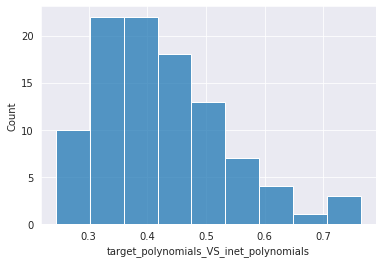

In [41]:
sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'] > -50])


<AxesSubplot:xlabel='target_polynomials_VS_lstsq_lambda_pred_polynomials', ylabel='Count'>

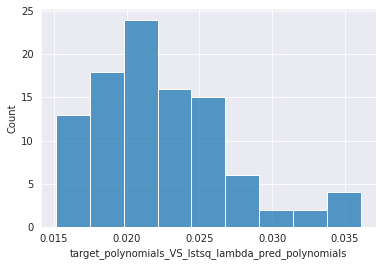

In [42]:
sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'] > -50])


[(-30.0, 1.0)]

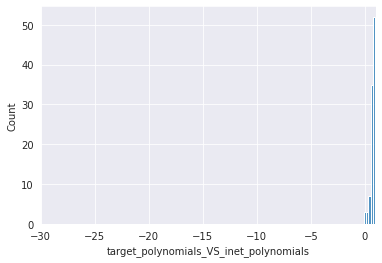

In [43]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'] > -50], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

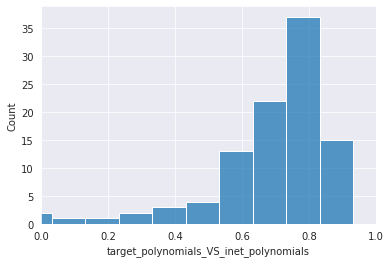

In [44]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

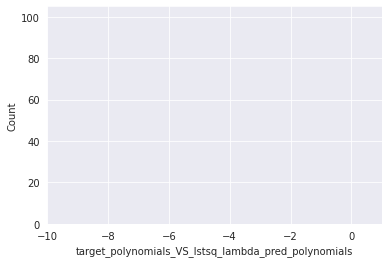

In [45]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'] > -50], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

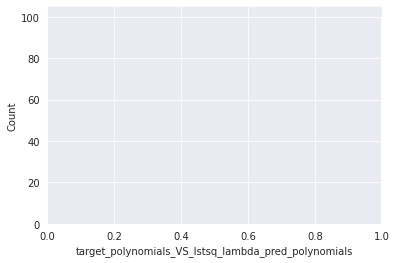

In [46]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

In [47]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


In [48]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [49]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [50]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [51]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [52]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_lambda_pred_polynomials


0.678*a**2 + 0.8355*a*b - 0.2384*a*c - 0.4715*a*d - 0.8046*a*e + 0.1833*a*f + 0.6255*a*g - 0.19*a*h + 0.1032*a*i - 0.5547*a + 0.396*b**2 - 0.7865*b*c + 0.2488*b*d + 0.3957*b*e - 0.4358*b*f + 0.661*b*g + 0.4235*b*h - 0.6903*b*i + 0.127*b - 0.1158*c**2 - 0.6942*c*d + 0.8486*c*e - 0.2072*c*f - 0.3406*c*g - 0.2997*c*h + 0.182*c*i + 0.8882*c + 0.4716*d**2 + 0.6241*d*e + 0.2125*d*f + 0.611*d*g - 0.577*d*h - 0.8431*d*i + 0.5097*d - 0.4233*e**2 + 0.5068*e*f + 0.5891*e*g + 0.4687*e*h - 0.5242*e*i + 0.5785*e - 0.2822*f**2 + 0.585*f*g + 0.6155*f*h + 0.056*f*i + 1.0189*f + 0.2587*g**2 + 0.8922*g*h - 0.2106*g*i + 0.9121*g - 0.1597*h**2 - 0.8185*h*i + 0.1011*h - 0.1985*i**2 - 1.1328*i - 0.9025

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_target_polynomials


0.7765*a**2 + 0.8941*a*b - 0.2528*a*c - 0.5208*a*d - 0.8138*a*e + 0.2254*a*f + 0.757*a*g - 0.2143*a*h + 0.1355*a*i - 0.7181*a + 0.3974*b**2 - 0.8031*b*c + 0.2526*b*d + 0.3854*b*e - 0.4218*b*f + 0.7305*b*g + 0.4798*b*h - 0.8264*b*i + 0.1063*b - 0.0859*c**2 - 0.7089*c*d + 0.8514*c*e - 0.2568*c*f - 0.4602*c*g - 0.2428*c*h + 0.1783*c*i + 0.9455*c + 0.5013*d**2 + 0.7171*d*e + 0.2431*d*f + 0.6248*d*g - 0.6263*d*h - 0.8748*d*i + 0.4461*d - 0.5334*e**2 + 0.6195*e*f + 0.6446*e*g + 0.5342*e*h - 0.5841*e*i + 0.5981*e - 0.3408*f**2 + 0.6429*f*g + 0.6658*f*h + 0.039*f*i + 0.9765*f + 0.3393*g**2 + 0.9124*g*h - 0.1935*g*i + 0.754*g - 0.1737*h**2 - 0.8596*h*i + 0.0731*h - 0.2858*i**2 - 0.9395*i - 0.8775

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target_polynomials


0.7765*a**2 + 0.8941*a*b - 0.2528*a*c - 0.5208*a*d - 0.8138*a*e + 0.2254*a*f + 0.757*a*g - 0.2143*a*h + 0.1355*a*i - 0.7181*a + 0.3974*b**2 - 0.8031*b*c + 0.2526*b*d + 0.3854*b*e - 0.4218*b*f + 0.7305*b*g + 0.4798*b*h - 0.8264*b*i + 0.1063*b - 0.0859*c**2 - 0.7089*c*d + 0.8514*c*e - 0.2568*c*f - 0.4602*c*g - 0.2428*c*h + 0.1783*c*i + 0.9455*c + 0.5013*d**2 + 0.7171*d*e + 0.2431*d*f + 0.6248*d*g - 0.6263*d*h - 0.8748*d*i + 0.4461*d - 0.5334*e**2 + 0.6195*e*f + 0.6446*e*g + 0.5342*e*h - 0.5841*e*i + 0.5981*e - 0.3408*f**2 + 0.6429*f*g + 0.6658*f*h + 0.039*f*i + 0.9765*f + 0.3393*g**2 + 0.9124*g*h - 0.1935*g*i + 0.754*g - 0.1737*h**2 - 0.8596*h*i + 0.0731*h - 0.2858*i**2 - 0.9395*i - 0.8775

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
inet_polynomials


-0.0854000002145767*a**2 - 0.0623000003397465*a*b - 0.0480000004172325*a*c - 0.063900001347065*a*d - 0.00730000017210841*a*e + 0.171200007200241*a*f + 0.241999998688698*a*g + 0.0419999994337559*a*h - 0.238800004124641*a*i - 0.063900001347065*a + 0.0230999998748302*b**2 - 0.285400003194809*b*c + 0.063000001013279*b*d - 0.0975999981164932*b*e + 0.241699993610382*b*f + 0.273900002241135*b*g + 0.151999995112419*b*h - 0.250499993562698*b*i + 0.0954999998211861*b + 0.0958999991416931*c**2 - 0.201700001955032*c*d + 0.0434999987483025*c*e + 0.0776999965310097*c*f + 0.281599998474121*c*g - 0.119199998676777*c*h - 0.298700004816055*c*i + 0.195199996232986*c + 0.236399993300438*d**2 + 0.125100001692772*d*e + 0.101999998092651*d*f + 0.550899982452393*d*g + 0.0052000000141561*d*h - 0.0308999996632338*d*i + 0.00920000020414591*d + 0.316199988126755*e**2 + 0.0688999965786934*e*f + 0.337300002574921*e*g + 0.010499999858439*e*h - 0.222399994730949*e*i + 0.0472000017762184*e + 0.154499992728233*f**2 + 0

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


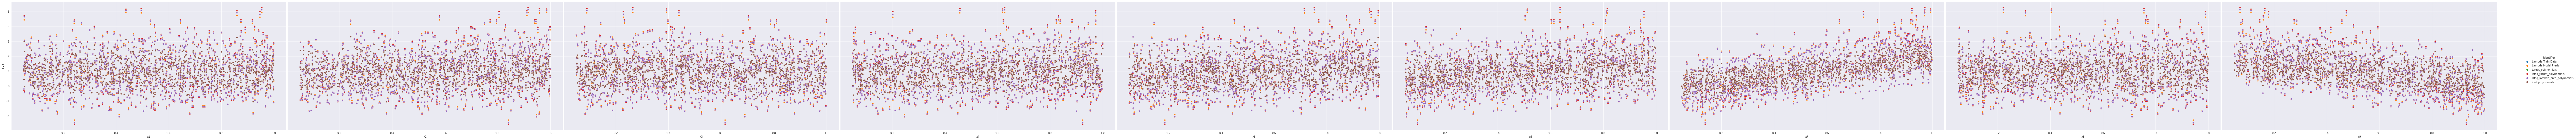

In [53]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

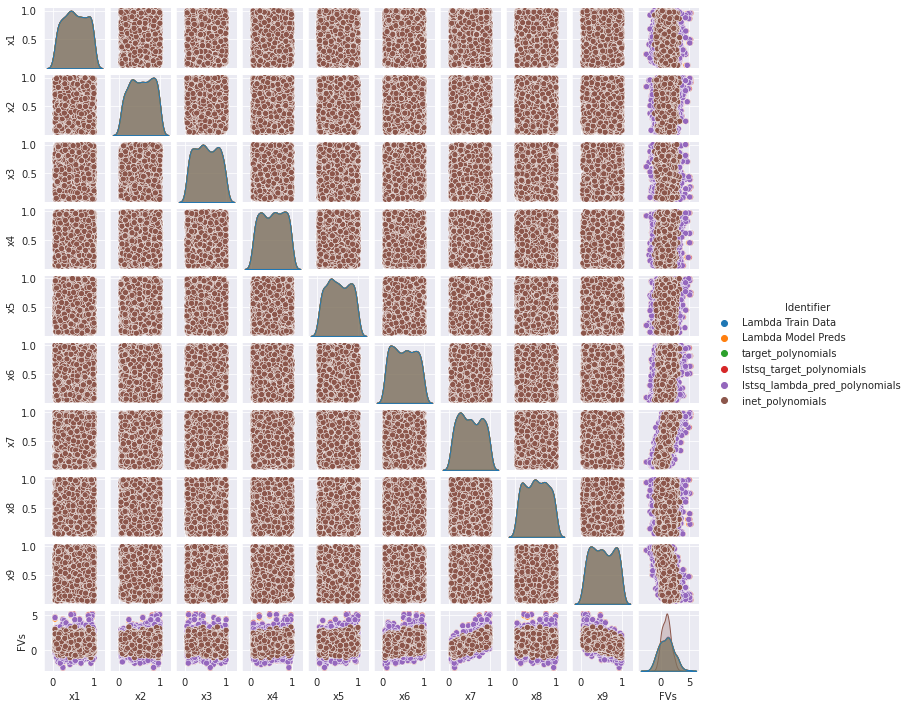

In [54]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

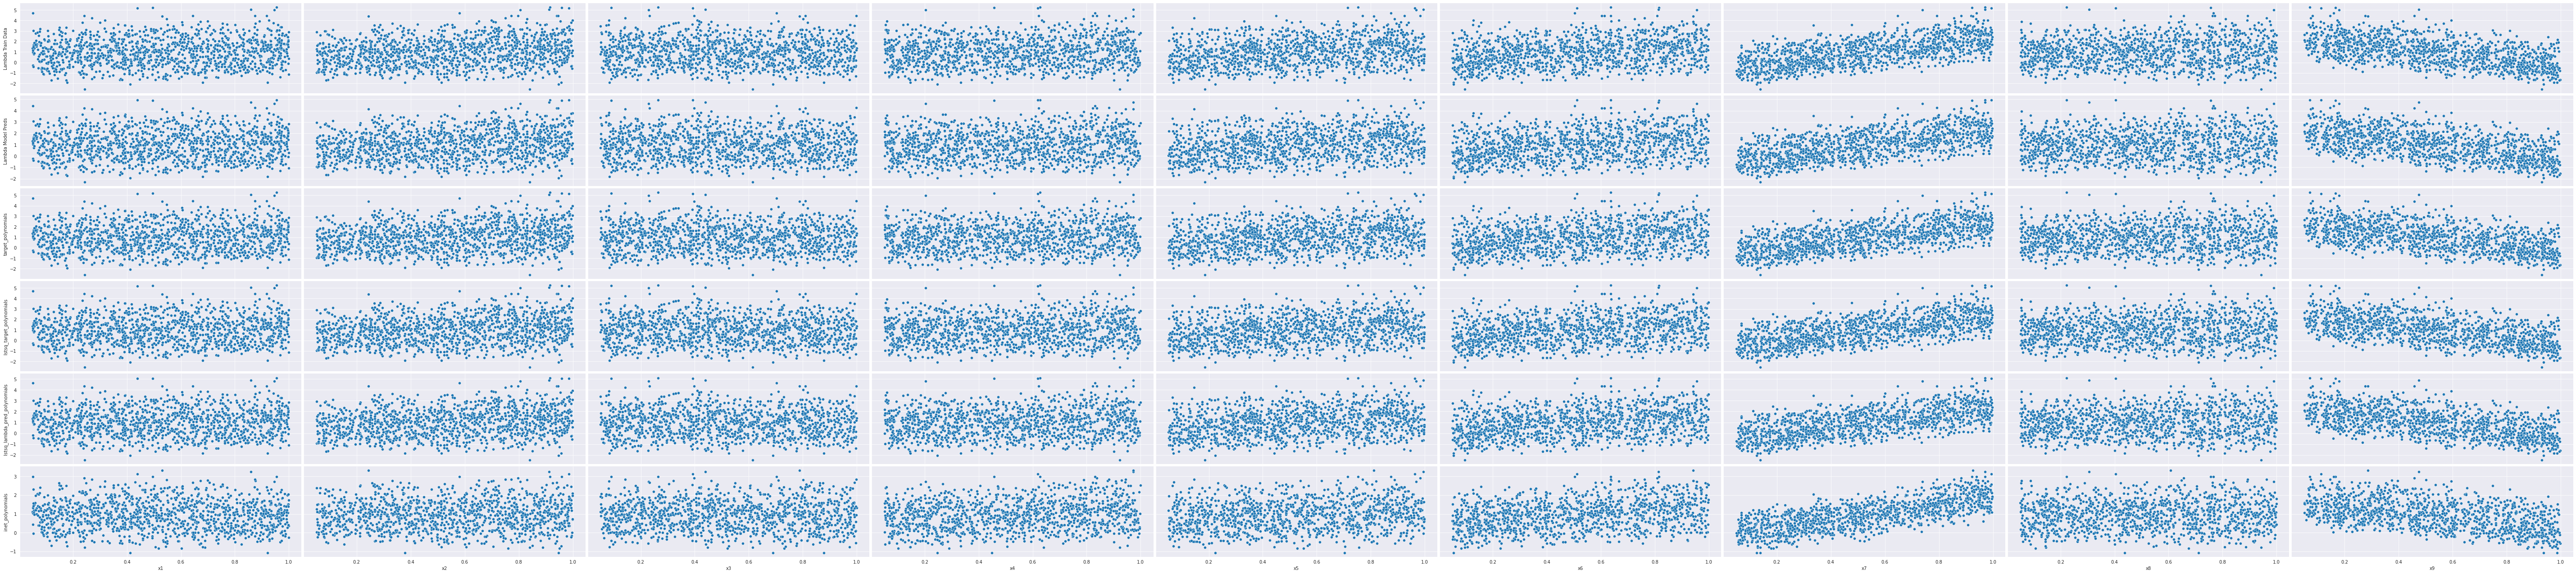

In [55]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [56]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [57]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  3.9min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 12.9min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  3.9min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 12.9min finished


In [58]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 4.9899


In [59]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 15.0878


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [60]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  3.9min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 12.9min finished


In [61]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 1.5255


In [62]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [63]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


Current best: 1.0086630582809448 
 Curr_res: 2.0901286602020264 
 Iteration 1, Step 10
Optimization terminated at 0.8063380718231201


array([ 0.3031576 , -0.00221959, -0.12945509,  0.41187057,  0.13764805,
       -0.3178984 ,  0.13792259, -0.22297946, -0.45772293,  0.3421984 ,
        0.40637505, -0.277438  ,  0.41985208,  0.18789664, -0.07294372,
        0.37816104,  0.19440189, -0.03431797,  0.02926347, -0.16980413,
       -0.3724468 , -0.3384619 ,  0.00851935, -0.05697662, -0.14793554,
        0.39692023, -0.2505862 ,  0.26328745,  0.35936108, -0.41519237,
       -0.2958078 , -0.21150479,  0.1514276 ,  0.21068114,  0.36950988,
       -0.26254413,  0.16889426,  0.21157259, -0.28099912,  0.27028504,
       -0.04943788,  0.45493945,  0.21696505,  0.4894608 , -0.3488813 ,
       -0.437591  , -0.34789687,  0.49522763,  0.28303224, -0.3954357 ,
       -0.09386379, -0.45311788,  0.33120063,  0.3572099 , -0.21528557],
      dtype=float32)

# Evaluate Real Dataset


##  Auto MPG-Dataset

In [65]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

Cylinders  Displacement  Horsepower  Weight  Acceleration  Model Year  \
0      1.000         0.618       0.457   0.536         0.238       0.000   
1      1.000         0.729       0.647   0.590         0.208       0.000   
2      1.000         0.646       0.565   0.517         0.179       0.000   
3      1.000         0.610       0.565   0.516         0.238       0.000   
4      1.000         0.605       0.511   0.521         0.149       0.000   

   Europe  Japan   USA  
0   0.000  0.000 1.000  
1   0.000  0.000 1.000  
2   0.000  0.000 1.000  
3   0.000  0.000 1.000  
4   0.000  0.000 1.000

In [66]:
#%load_ext autoreload

In [67]:
np.isinf(features_autoMPG_model.values).any()

False

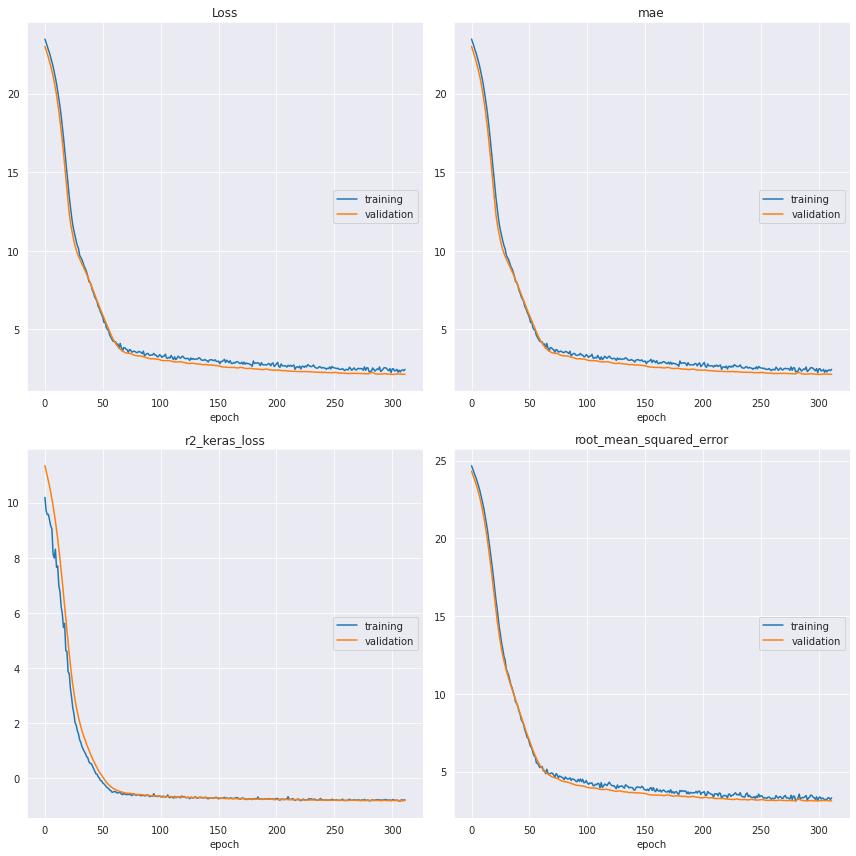

Loss
	training         	 (min:    2.239, max:   23.460, cur:    2.457)
	validation       	 (min:    2.131, max:   22.997, cur:    2.137)
mae
	training         	 (min:    2.239, max:   23.460, cur:    2.457)
	validation       	 (min:    2.131, max:   22.997, cur:    2.137)
r2_keras_loss
	training         	 (min:   -0.836, max:   10.189, cur:   -0.797)
	validation       	 (min:   -0.820, max:   11.340, cur:   -0.820)
root_mean_squared_error
	training         	 (min:    3.107, max:   24.673, cur:    3.308)
	validation       	 (min:    3.115, max:   24.326, cur:    3.119)


In [68]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[42+2], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [ ]:
if interpretation_possible_autoMPG and n==1:
    x = tf.linspace(0.0, 1, 250)#tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [ ]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, normalized=False, normalization_parameter_dict=None)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function:')
    #display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    #ax.set_ylim([0,1])
    ax.set_ylim([0,100])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function:')
    #display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    #ax.set_ylim([0,1])
    ax.set_ylim([0,100])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])


In [ ]:
current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 

In [ ]:
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

In [ ]:
model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

In [ ]:
model.get_weights()

In [ ]:
model.predict([1, 10])

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 

In [ ]:
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

In [ ]:
model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

In [ ]:
model.get_weights()

In [ ]:
model.predict([1, 10])

In [ ]:
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

In [ ]:
model.fit(sample_data_X,
         sample_data_y,
         epochs=500,
         verbose=0)

In [ ]:
model_2 = keras.models.clone_model(model)

model_2.summary()

In [ ]:
model.get_weights()

In [ ]:
model.predict([1, 10])

In [ ]:
model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]

In [ ]:
model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

In [ ]:
#model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/1000
#model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

In [ ]:
model_2.set_weights(model_2_normalized_weights)

In [ ]:
model_2.get_weights()

In [ ]:
model_2.predict([1, 10])

In [ ]:
    #Plot Polynom, lamdba net, and Interpration net
    length_plt = len(plot_metric_list)
    if length_plt >= 2:
        fig, ax = plt.subplots(length_plt//2, 2, figsize=(30,20))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(20,10))

    for index, metric in enumerate(plot_metric_list):
        
        plot_scores_dict = {}
        for key in evaluation_key_list:
            try:
                scores_list[-1][metric].loc[key]
                plot_scores_dict[key] = []
            except:
                #print(key + 'not in scores_list')
                continue
            
        
        for scores in scores_list:
            for key in evaluation_key_list:
                try:
                    plot_scores_dict[key].append(scores[metric].loc[key])
                except:
                    #print(key + 'not in scores_list')
                    continue
                                        
            
        plot_df = pd.DataFrame(data=np.vstack(plot_scores_dict.values()).T, 
                               index=x_axis_steps,
                               columns=plot_scores_dict.keys())

        if length_plt >= 2:
            ax[index//2, index%2].set_title(metric)
            sns.set(font_scale = 1.25)
            p = sns.lineplot(data=plot_df, ax=ax[index//2, index%2])
        else:
            ax.set_title(metric)
            sns.set(font_scale = 1.25)
            p = sns.lineplot(data=plot_df, ax=ax)

        if ylim != None:
            p.set(ylim=ylim)

        p.set_yticklabels(np.round(p.get_yticks(), 2), size = 20)
        p.set_xticklabels(p.get_xticks(), size = 20)     
        
        #p.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        p.legend(loc='upper center', bbox_to_anchor=(0.47, -0.1),
          fancybox=False, shadow=False, ncol=2, fontsize=12)   
        
    plt.subplots_adjust(wspace=0.1, hspace=0.75)

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()